In [21]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.integrate import odeint
from src import visualize_n_points

np.set_printoptions(precision=3, suppress=True)

### System for consideration:

<p align="center">
<img src="system.png" alt="drawing" width="100%" style="margin:auto"/>
</p>

* Here desired trajectory is dashed line
* Desired law: $x_2^* = l$, $y_2^* = l(\sin t - 0.2)$, or $\mathbf{q}^d = \begin{bmatrix} l & l(\sin t + 0.2) \end{bmatrix}^T$

## Proposed control

$$
\begin{bmatrix}
M(\mathbf{q}) & J^T(\mathbf{q}) & P^T \\
J(\mathbf{q}) & \mathbf{0} & \mathbf{0} \\
P & \mathbf{0} & \mathbf{0}
\end{bmatrix}
\begin{bmatrix}
\mathbf{\ddot{q}} \\
\mathbf{\lambda} \\
-\mathbf{u}
\end{bmatrix}
= 
\begin{bmatrix}
-h(\mathbf{q}, \mathbf{\dot{q}}) \\
-\dot{J}(\mathbf{q}) \mathbf{\dot{q}} \\
\mathbf{\ddot{q}}^d - K_D \mathbf{\tilde{\dot{q}}} - K_P \mathbf{\tilde{q}}
\end{bmatrix}
$$

where (in our case):

$q = \begin{bmatrix} x_1 & y_1 & x_2 & y_2 \end{bmatrix}^T$, $u = \begin{bmatrix} F_{x_2} & F_{y_2} \end{bmatrix}^T$ and $P = \begin{bmatrix} 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \end{bmatrix}$,
$h(\mathbf{q}, \mathbf{\dot{q}}) = C(\mathbf{q}, \mathbf{\dot{q}}) \mathbf{\dot{q}} + g(\mathbf{q}) = h(\mathbf{q}, \mathbf{\dot{q}}) = \begin{bmatrix} 0 & mg & 0 & mg \end{bmatrix}^T$, $M(\mathbf{q}) = m \mathbf{I}_{4 \times 4}$ and $J(\mathbf{q}) = 2 \begin{bmatrix} x_1 & y_1 & 0 & 0 \\ x_1 - x_2 & y_1 - y_2 & x_2 - x_1 & y_2 - y_1 \end{bmatrix}$,
$\mathbf{\ddot{q}}^d = \begin{bmatrix} 0 & -l \sin t \end{bmatrix}^T$, $\mathbf{\tilde{\dot{q}}} = \begin{bmatrix} \dot{x}_2 & \dot{y}_2 - l \cos t \end{bmatrix}^T$ and $\mathbf{\tilde{q}} = \begin{bmatrix} x_2 - l & y_2 - l (\sin t + 0.2) \end{bmatrix}^T$


## Initial conditions:

$\mathbf{q}_0 = \begin{bmatrix} l & 0 & 2l & 0 \end{bmatrix}^T$ and $\mathbf{\dot{q}}_0 = \begin{bmatrix} 0 & 0 & 0 & 0 \end{bmatrix}^T$

In [75]:
L = 1
M = 1
G = 10
Q_0 = np.array([L, 0, 2 * L, 0])
DOT_Q_0 = np.array([0, 0, 0, 0])
P_MAT = np.array([[0, 0, 1, 0], [0, 0, 0, 1]])
K_D = 2 * np.eye(2)
K_P = np.eye(2)


def jac_constraint(q: np.ndarray) -> np.ndarray:
    x_1, y_1, x_2, y_2 = q
    return 2 * np.array(
        [
            [x_1, y_1, 0, 0],
            [x_1 - x_2, y_1 - y_2, x_2 - x_1, y_2 - y_1],
        ]
    )


def dot_jac_constraint(_: np.ndarray, dot_q: np.ndarray) -> np.ndarray:
    dot_x_1, dot_y_1, dot_x_2, dot_y_2 = dot_q
    return 2 * np.array(
        [
            [dot_x_1, dot_y_1, 0, 0],
            [dot_x_1 - dot_x_2, dot_y_1 - dot_y_2, dot_x_2 - dot_x_1, dot_y_2 - dot_y_1],
        ]
    )


def h_val(_: np.ndarray, __: np.ndarray) -> np.ndarray:
    return np.array([0, M * G, 0, M * G])


def mass_matrix(_: np.ndarray) -> np.ndarray:
    return M * np.eye(4)


def ddot_q_desired(t: float) -> np.ndarray:
    return np.array([0, -L * np.sin(t)])


def dot_q_tilda(dot_q: np.ndarray, t: float) -> np.ndarray:
    _, _, dot_x_2, dot_y_2 = dot_q
    return np.array([dot_x_2, dot_y_2 - L * np.cos(t)])


def q_tilda(q: np.ndarray, t: float) -> np.ndarray:
    _, _, x_2, y_2 = q
    return np.array([x_2 - L, y_2 - L * (np.sin(t) + 0.2)])


def full_matrix(q: np.ndarray) -> np.ndarray:
    res = np.zeros((8, 8))

    res[:4, :4] = mass_matrix(q)
    res[:4, 4:6] = jac_constraint(q).T
    res[4:6, :4] = jac_constraint(q)
    res[:4, 6:] = P_MAT.T
    res[6:, :4] = P_MAT

    return res

In [76]:
print(full_matrix(Q_0))  # <- Singular matrix

[[ 1.  0.  0.  0.  2. -2.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  2.  1.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  1.]
 [ 2.  0.  0.  0.  0.  0.  0.  0.]
 [-2.  0.  2.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.]]


## Why it's failed again?

Consider leftmost matrix of proposed control as $N$, then:

$$
N = 
\begin{bmatrix}
M & B \\ B^T & 0
\end{bmatrix},
\: \text{where} \:
B = \begin{bmatrix} J^T & P^T \end{bmatrix}
$$

Thus, Schur compliment would be: $N / M = -B^T M^{-1} B$, in our case ($m = 1$ and $l = 1$) $N / B = -B^T B$

For initial moment of time: $B = \begin{bmatrix} 2 & -2 & 0 & 0 \\ 0 & 0 & 0 & 0 \\ 0 & 2 & 1 & 0 \\ 0 & 0 & 0 & 1\end{bmatrix}$ and $-B^T B = \begin{bmatrix} -4 & 4 & 0 & 0 \\ 4 & -8 & -2 & 0 \\ 0 & -2 & -1 & 0 \\ 0 & 0 & 0 & -1\end{bmatrix}$, so $\text{rank}(-B^T B) = 3$

Using Guttman rank additivity formula, we obtain $\text{rank}(N) = \text{rank}(M) + \text{rank}(N / M) = 7$, but $N \in \mathbb{R}^{8 \times 8}$. Therefore, $N$ is singular

To conclude, if we want to achieve non-singularity of $N$, we should prove that $B$ is non-singular too


## Another initial conditions:

$\mathbf{q}_0 = \begin{bmatrix} \frac{l}{2} & \frac{l \sqrt{3}}{2} & l & 0 \end{bmatrix}^T$ and $\mathbf{\dot{q}}_0 = \begin{bmatrix} 0 & 0 & 0 & 0 \end{bmatrix}^T$

In [77]:
Q_0 = np.array([L / 2, L * np.sqrt(3) / 2, L, 0])

print(full_matrix(Q_0))  # <- now it's non-singular

[[ 1.     0.     0.     0.     1.    -1.     0.     0.   ]
 [ 0.     1.     0.     0.     1.732  1.732  0.     0.   ]
 [ 0.     0.     1.     0.     0.     1.     1.     0.   ]
 [ 0.     0.     0.     1.     0.    -1.732  0.     1.   ]
 [ 1.     1.732  0.     0.     0.     0.     0.     0.   ]
 [-1.     1.732  1.    -1.732  0.     0.     0.     0.   ]
 [ 0.     0.     1.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     1.     0.     0.     0.     0.   ]]


In [78]:
def right_side(q: np.ndarray, dot_q: np.ndarray, t: float) -> np.ndarray:
    h_v = h_val(q, dot_q)
    dot_jac = dot_jac_constraint(q, dot_q)
    dump = ddot_q_desired(t) - K_D.dot(dot_q_tilda(dot_q, t)) - K_P.dot(q_tilda(q, t))
    return np.r_[-h_v, -dot_jac.dot(dot_q), dump]


def state(x: np.ndarray, t: float) -> np.ndarray:
    q = x[:4]
    dot_q = x[4:]
    right = right_side(q, dot_q, t)
    n_mat = full_matrix(q)
    try:
        inv_n_mat = np.linalg.inv(n_mat)
    except np.linalg.LinAlgError as e:
        print(e)
        print(q, dot_q, t)
        print(n_mat)
        exit(1)
    return np.r_[dot_q, inv_n_mat.dot(right)[:4]]


def control(x: np.ndarray, t: float) -> np.ndarray:
    q = x[:4]
    dot_q = x[4:]
    right = right_side(q, dot_q, t)
    n_mat = full_matrix(q)
    try:
        inv_n_mat = np.linalg.inv(n_mat)
    except np.linalg.LinAlgError as e:
        print(e)
        print(q, dot_q, t)
        print(n_mat)
        exit(1)
    return -inv_n_mat.dot(right)[-2:]

In [79]:
N = 1000
T_FINAL = 10
T_SPAN = np.linspace(0, T_FINAL, N)
X_0 = np.r_[Q_0, DOT_Q_0]

sol = odeint(state, X_0, T_SPAN)
control_vals = np.array([control(x, t) for x, t in zip(sol, T_SPAN)])
error = np.linalg.norm(np.array([q_tilda(q, t) for q, t in zip(sol[:, :4], T_SPAN)]), axis=1)

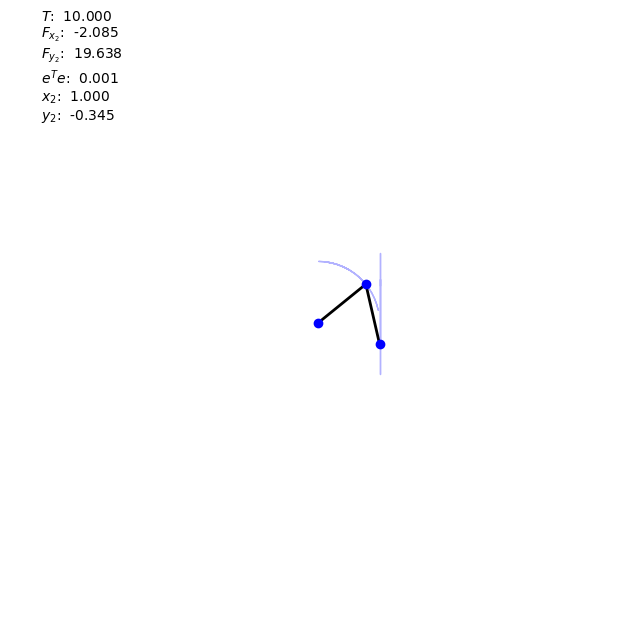

In [80]:
visualize_n_points(
    points=[np.zeros((N, 2)), sol[:, :2], sol[:, 2:4]],
    lines_defs=[(0, 1), (1, 2)],
    stats=[
        ('$T$', T_SPAN), 
        ('$F_{x_2}$', control_vals[:, 0]),
        ('$F_{y_2}$', control_vals[:, 1]),
        ('$e^T e$', error),
        ('$x_2$', sol[:, 2]),
        ('$y_2$', sol[:, 3]),
    ],
    figsize=(8, 8),
    dt=0.5,
)